In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

import pandas as pd
from torch import nn, optim

from sklearn.metrics import confusion_matrix

In [2]:
#from nni_assets.compression.mnist_model import TorchModel, trainer, evaluator, device
from nni.compression.pytorch.pruning import L1NormPruner
from nni.compression.pytorch.pruning import L2NormPruner

In [3]:
from ConvNet import ConvNet
from DatasetEcg import DatasetECG

In [4]:
train_pth = 'sh_dataset\\train\\'

val_pth = 'sh_dataset\\validation\\'

model_name = 'model'

DIR = 'models\\main_model_pr_am\\'

MODEL_PATH = 'models\\main_model\\model21.pth'

batch_size = 16

train_ds_ecg = DatasetECG(train_pth)
val_ds_ecg = DatasetECG(val_pth)

train_loader = torch.utils.data.DataLoader(
    train_ds_ecg, shuffle=True, 
    batch_size=batch_size, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds_ecg, shuffle=True,
    batch_size=batch_size, drop_last=True
)

7500
1250


In [5]:
model = torch.load(MODEL_PATH)

In [6]:
model

ConvNet(
  (act): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (linear0): Linear(in_features=15488, out_features=512, bias=True)
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=5, bias=True)
)

In [7]:
spars_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 0.95]

In [8]:
train_losses=[]
train_accu=[]

eval_losses=[]
eval_accu=[]

In [9]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(train_loader):
    inputs = data[0].to(device, non_blocking=True)
    labels=data[1].to(device, non_blocking=True)

    outputs=model(inputs)

    loss=loss_fn(outputs,labels)

    #Replaces pow(2.0) with abs() for L1 regularization

    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

      
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total

  train_accu.append(accu)
  train_losses.append(train_loss)
  

In [10]:
def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():

    for data in tqdm(val_loader):
      images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)

      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()


  test_loss=running_loss/len(val_loader)
  accu=100.*correct/total
  
  eval_losses.append(test_loss)
  eval_accu.append(accu)

In [11]:
acc_list = []
ft_acc_list = []

for sp in spars_lst:
    config_list = [{
    'sparsity_per_layer': sp,
    'op_types': ['Linear', 'Conv2d']
}, {
    'exclude': True,
    'op_names': ['linear2']
}]
    model = torch.load(MODEL_PATH)

    pruner = L2NormPruner(model, config_list)

    # compress the model and generate the masks
    _, masks = pruner.compress()

    device = 'cuda'

    # need to unwrap the model, if the model is wrapped before speedup
    pruner._unwrap_model()
    
    # speedup the model, for more information about speedup, please refer :doc:`pruning_speedup`.
    from nni.compression.pytorch.speedup import ModelSpeedup
    
    ModelSpeedup(model, torch.rand(1, 1, 128, 128).to(device), masks).speedup_model()

    torch.save(model.state_dict(), DIR + 'dp_' + model_name + str(int(sp*100)) + '.pth')
    torch.save(model, DIR + 'p_' + model_name + str(int(sp*100)) + '.pth')

    model.eval()

    correct=0
    total=0
    
    with torch.no_grad():
      for data in val_loader:
        images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
        
        outputs=model(images)
            
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accu=100.*correct/total
    acc_list.append(accu)
    

    train_losses=[]
    train_accu=[]

    eval_losses=[]
    eval_accu=[]

    max_accuracy = 0
    loss_fn=nn.CrossEntropyLoss()
    optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
    
    epochs = 1
    
    device = 'cuda'
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    use_amp = True
    scaler = torch.cuda.amp.GradScaler()
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
    for epoch in range(1,epochs+1): 
      MOD_PTH = DIR + 'ft_' + model_name + str(int(sp*100)) + '_' + str(epoch) + '.pth'
      D_MOD_PTH = DIR + 'd_ft_' + model_name + str(int(sp*100)) + '_' + str(epoch) + '.pth'
      train(epoch)
      test(epoch)
      acc_ep = eval_accu[-1]

      if acc_ep > max_accuracy:
        max_accuracy = acc_ep    
        torch.save(model, MOD_PTH)
        torch.save(model.state_dict(), D_MOD_PTH)

    ft_acc_list.append(max_accuracy)

    np.save(DIR + model_name + 'pr_train_accu_' + str(int(sp*100)), train_accu)
    np.save(DIR + model_name + 'pr_eval_accu_' + str(int(sp*100)), eval_accu)


np.save(DIR + model_name + 'pr_acc', acc_list)
np.save(DIR + model_name + 'ft_pr_acc', ft_acc_list)       

[2023-06-13 17:35:08] start to speedup the model
[2023-06-13 17:35:08] infer module masks...
[2023-06-13 17:35:08] Update mask for conv0
[2023-06-13 17:35:08] Update mask for act
[2023-06-13 17:35:08] Update mask for maxpool
[2023-06-13 17:35:08] Update mask for conv1
[2023-06-13 17:35:08] Update mask for act
[2023-06-13 17:35:08] Update mask for maxpool
[2023-06-13 17:35:08] Update mask for conv2
[2023-06-13 17:35:08] Update mask for act
[2023-06-13 17:35:08] Update mask for maxpool
[2023-06-13 17:35:08] Update mask for conv3
[2023-06-13 17:35:08] Update mask for act
[2023-06-13 17:35:08] Update mask for .aten::flatten.16
[2023-06-13 17:35:08] Update mask for linear0
[2023-06-13 17:35:08] Update mask for act
[2023-06-13 17:35:08] Update mask for linear1
[2023-06-13 17:35:08] Update mask for act
[2023-06-13 17:35:08] Update mask for linear2
[2023-06-13 17:35:08] Update the indirect sparsity for the linear2
[2023-06-13 17:35:08] Update the indirect sparsity for the act.5
[2023-06-13 17:

d:\Andrey\1\diplom\ecg_classification\env\lib\site-packages\nni\compression\pytorch\speedup\infer_mask.py:275: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:491.)
  if isinstance(self.output, torch.Tensor) and self.output.grad is not None:
d:\Andrey\1\diplom\ecg_classification\env\lib\site-packages\nni\compression\pytorch\speedup\compressor.py:305: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during a

[2023-06-13 17:35:10] Update the indirect sparsity for the maxpool.2
[2023-06-13 17:35:10] Update the indirect sparsity for the act.2
[2023-06-13 17:35:10] Update the indirect sparsity for the conv2
[2023-06-13 17:35:10] Update the indirect sparsity for the maxpool.1
[2023-06-13 17:35:10] Update the indirect sparsity for the act.1
[2023-06-13 17:35:10] Update the indirect sparsity for the conv1
[2023-06-13 17:35:10] Update the indirect sparsity for the maxpool
[2023-06-13 17:35:10] Update the indirect sparsity for the act
[2023-06-13 17:35:10] Update the indirect sparsity for the conv0
[2023-06-13 17:35:10] resolve the mask conflict
[2023-06-13 17:35:10] replace compressed modules...
[2023-06-13 17:35:10] replace module (name: conv0, op_type: Conv2d)
[2023-06-13 17:35:10] replace module (name: act, op_type: ReLU)
[2023-06-13 17:35:10] replace module (name: maxpool, op_type: MaxPool2d)
[2023-06-13 17:35:10] replace module (name: conv1, op_type: Conv2d)
[2023-06-13 17:35:10] replace modu

100%|██████████| 78/78 [00:01<00:00, 40.25it/s]


[2023-06-13 17:37:45] start to speedup the model
[2023-06-13 17:37:45] infer module masks...
[2023-06-13 17:37:45] Update mask for conv0
[2023-06-13 17:37:45] Update mask for act
[2023-06-13 17:37:45] Update mask for maxpool
[2023-06-13 17:37:45] Update mask for conv1
[2023-06-13 17:37:45] Update mask for act
[2023-06-13 17:37:45] Update mask for maxpool
[2023-06-13 17:37:45] Update mask for conv2
[2023-06-13 17:37:45] Update mask for act
[2023-06-13 17:37:45] Update mask for maxpool
[2023-06-13 17:37:45] Update mask for conv3
[2023-06-13 17:37:45] Update mask for act
[2023-06-13 17:37:45] Update mask for .aten::flatten.16
[2023-06-13 17:37:45] Update mask for linear0
[2023-06-13 17:37:45] Update mask for act
[2023-06-13 17:37:45] Update mask for linear1
[2023-06-13 17:37:45] Update mask for act
[2023-06-13 17:37:45] Update mask for linear2
[2023-06-13 17:37:45] Update the indirect sparsity for the linear2
[2023-06-13 17:37:45] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 80.39it/s]


[2023-06-13 17:38:04] start to speedup the model
[2023-06-13 17:38:04] infer module masks...
[2023-06-13 17:38:04] Update mask for conv0
[2023-06-13 17:38:04] Update mask for act
[2023-06-13 17:38:04] Update mask for maxpool
[2023-06-13 17:38:04] Update mask for conv1
[2023-06-13 17:38:04] Update mask for act
[2023-06-13 17:38:04] Update mask for maxpool
[2023-06-13 17:38:04] Update mask for conv2
[2023-06-13 17:38:04] Update mask for act
[2023-06-13 17:38:04] Update mask for maxpool
[2023-06-13 17:38:04] Update mask for conv3
[2023-06-13 17:38:04] Update mask for act
[2023-06-13 17:38:04] Update mask for .aten::flatten.16
[2023-06-13 17:38:04] Update mask for linear0
[2023-06-13 17:38:04] Update mask for act
[2023-06-13 17:38:04] Update mask for linear1
[2023-06-13 17:38:04] Update mask for act
[2023-06-13 17:38:04] Update mask for linear2
[2023-06-13 17:38:04] Update the indirect sparsity for the linear2
[2023-06-13 17:38:04] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 81.97it/s]


[2023-06-13 17:38:16] start to speedup the model
[2023-06-13 17:38:16] infer module masks...
[2023-06-13 17:38:16] Update mask for conv0
[2023-06-13 17:38:16] Update mask for act
[2023-06-13 17:38:16] Update mask for maxpool
[2023-06-13 17:38:16] Update mask for conv1
[2023-06-13 17:38:16] Update mask for act
[2023-06-13 17:38:16] Update mask for maxpool
[2023-06-13 17:38:16] Update mask for conv2
[2023-06-13 17:38:16] Update mask for act
[2023-06-13 17:38:16] Update mask for maxpool
[2023-06-13 17:38:16] Update mask for conv3
[2023-06-13 17:38:16] Update mask for act
[2023-06-13 17:38:16] Update mask for .aten::flatten.16
[2023-06-13 17:38:16] Update mask for linear0
[2023-06-13 17:38:16] Update mask for act
[2023-06-13 17:38:16] Update mask for linear1
[2023-06-13 17:38:16] Update mask for act
[2023-06-13 17:38:16] Update mask for linear2
[2023-06-13 17:38:16] Update the indirect sparsity for the linear2
[2023-06-13 17:38:16] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 84.25it/s]


[2023-06-13 17:38:27] start to speedup the model
[2023-06-13 17:38:27] infer module masks...
[2023-06-13 17:38:27] Update mask for conv0
[2023-06-13 17:38:27] Update mask for act
[2023-06-13 17:38:27] Update mask for maxpool
[2023-06-13 17:38:27] Update mask for conv1
[2023-06-13 17:38:27] Update mask for act
[2023-06-13 17:38:27] Update mask for maxpool
[2023-06-13 17:38:27] Update mask for conv2
[2023-06-13 17:38:27] Update mask for act
[2023-06-13 17:38:27] Update mask for maxpool
[2023-06-13 17:38:27] Update mask for conv3
[2023-06-13 17:38:27] Update mask for act
[2023-06-13 17:38:27] Update mask for .aten::flatten.16
[2023-06-13 17:38:27] Update mask for linear0
[2023-06-13 17:38:27] Update mask for act
[2023-06-13 17:38:27] Update mask for linear1
[2023-06-13 17:38:27] Update mask for act
[2023-06-13 17:38:27] Update mask for linear2
[2023-06-13 17:38:27] Update the indirect sparsity for the linear2
[2023-06-13 17:38:27] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 85.03it/s]


[2023-06-13 17:38:39] start to speedup the model
[2023-06-13 17:38:39] infer module masks...
[2023-06-13 17:38:39] Update mask for conv0
[2023-06-13 17:38:39] Update mask for act
[2023-06-13 17:38:39] Update mask for maxpool
[2023-06-13 17:38:39] Update mask for conv1
[2023-06-13 17:38:39] Update mask for act
[2023-06-13 17:38:39] Update mask for maxpool
[2023-06-13 17:38:39] Update mask for conv2
[2023-06-13 17:38:39] Update mask for act
[2023-06-13 17:38:39] Update mask for maxpool
[2023-06-13 17:38:39] Update mask for conv3
[2023-06-13 17:38:39] Update mask for act
[2023-06-13 17:38:39] Update mask for .aten::flatten.16
[2023-06-13 17:38:39] Update mask for linear0
[2023-06-13 17:38:39] Update mask for act
[2023-06-13 17:38:39] Update mask for linear1
[2023-06-13 17:38:39] Update mask for act
[2023-06-13 17:38:39] Update mask for linear2
[2023-06-13 17:38:39] Update the indirect sparsity for the linear2
[2023-06-13 17:38:39] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 85.68it/s]


[2023-06-13 17:38:50] start to speedup the model
[2023-06-13 17:38:50] infer module masks...
[2023-06-13 17:38:50] Update mask for conv0
[2023-06-13 17:38:50] Update mask for act
[2023-06-13 17:38:50] Update mask for maxpool
[2023-06-13 17:38:50] Update mask for conv1
[2023-06-13 17:38:50] Update mask for act
[2023-06-13 17:38:50] Update mask for maxpool
[2023-06-13 17:38:50] Update mask for conv2
[2023-06-13 17:38:50] Update mask for act
[2023-06-13 17:38:50] Update mask for maxpool
[2023-06-13 17:38:50] Update mask for conv3
[2023-06-13 17:38:50] Update mask for act
[2023-06-13 17:38:50] Update mask for .aten::flatten.16
[2023-06-13 17:38:50] Update mask for linear0
[2023-06-13 17:38:50] Update mask for act
[2023-06-13 17:38:50] Update mask for linear1
[2023-06-13 17:38:50] Update mask for act
[2023-06-13 17:38:50] Update mask for linear2
[2023-06-13 17:38:50] Update the indirect sparsity for the linear2
[2023-06-13 17:38:50] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 84.18it/s]


[2023-06-13 17:39:00] start to speedup the model
[2023-06-13 17:39:01] infer module masks...
[2023-06-13 17:39:01] Update mask for conv0
[2023-06-13 17:39:01] Update mask for act
[2023-06-13 17:39:01] Update mask for maxpool
[2023-06-13 17:39:01] Update mask for conv1
[2023-06-13 17:39:01] Update mask for act
[2023-06-13 17:39:01] Update mask for maxpool
[2023-06-13 17:39:01] Update mask for conv2
[2023-06-13 17:39:01] Update mask for act
[2023-06-13 17:39:01] Update mask for maxpool
[2023-06-13 17:39:01] Update mask for conv3
[2023-06-13 17:39:01] Update mask for act
[2023-06-13 17:39:01] Update mask for .aten::flatten.16
[2023-06-13 17:39:01] Update mask for linear0
[2023-06-13 17:39:01] Update mask for act
[2023-06-13 17:39:01] Update mask for linear1
[2023-06-13 17:39:01] Update mask for act
[2023-06-13 17:39:01] Update mask for linear2
[2023-06-13 17:39:01] Update the indirect sparsity for the linear2
[2023-06-13 17:39:01] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 83.75it/s]


[2023-06-13 17:39:11] start to speedup the model
[2023-06-13 17:39:11] infer module masks...
[2023-06-13 17:39:11] Update mask for conv0
[2023-06-13 17:39:11] Update mask for act
[2023-06-13 17:39:11] Update mask for maxpool
[2023-06-13 17:39:11] Update mask for conv1
[2023-06-13 17:39:11] Update mask for act
[2023-06-13 17:39:11] Update mask for maxpool
[2023-06-13 17:39:11] Update mask for conv2
[2023-06-13 17:39:11] Update mask for act
[2023-06-13 17:39:11] Update mask for maxpool
[2023-06-13 17:39:11] Update mask for conv3
[2023-06-13 17:39:11] Update mask for act
[2023-06-13 17:39:11] Update mask for .aten::flatten.16
[2023-06-13 17:39:11] Update mask for linear0
[2023-06-13 17:39:11] Update mask for act
[2023-06-13 17:39:11] Update mask for linear1
[2023-06-13 17:39:11] Update mask for act
[2023-06-13 17:39:11] Update mask for linear2
[2023-06-13 17:39:11] Update the indirect sparsity for the linear2
[2023-06-13 17:39:11] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 83.63it/s]


[2023-06-13 17:39:22] start to speedup the model
[2023-06-13 17:39:22] infer module masks...
[2023-06-13 17:39:22] Update mask for conv0
[2023-06-13 17:39:22] Update mask for act
[2023-06-13 17:39:22] Update mask for maxpool
[2023-06-13 17:39:22] Update mask for conv1
[2023-06-13 17:39:22] Update mask for act
[2023-06-13 17:39:22] Update mask for maxpool
[2023-06-13 17:39:22] Update mask for conv2
[2023-06-13 17:39:22] Update mask for act
[2023-06-13 17:39:22] Update mask for maxpool
[2023-06-13 17:39:22] Update mask for conv3
[2023-06-13 17:39:22] Update mask for act
[2023-06-13 17:39:22] Update mask for .aten::flatten.16
[2023-06-13 17:39:22] Update mask for linear0
[2023-06-13 17:39:22] Update mask for act
[2023-06-13 17:39:22] Update mask for linear1
[2023-06-13 17:39:22] Update mask for act
[2023-06-13 17:39:22] Update mask for linear2
[2023-06-13 17:39:22] Update the indirect sparsity for the linear2
[2023-06-13 17:39:22] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 81.66it/s]


[2023-06-13 17:39:33] start to speedup the model
[2023-06-13 17:39:33] infer module masks...
[2023-06-13 17:39:33] Update mask for conv0
[2023-06-13 17:39:33] Update mask for act
[2023-06-13 17:39:33] Update mask for maxpool
[2023-06-13 17:39:33] Update mask for conv1
[2023-06-13 17:39:33] Update mask for act
[2023-06-13 17:39:33] Update mask for maxpool
[2023-06-13 17:39:33] Update mask for conv2
[2023-06-13 17:39:33] Update mask for act
[2023-06-13 17:39:33] Update mask for maxpool
[2023-06-13 17:39:33] Update mask for conv3
[2023-06-13 17:39:33] Update mask for act
[2023-06-13 17:39:33] Update mask for .aten::flatten.16
[2023-06-13 17:39:33] Update mask for linear0
[2023-06-13 17:39:33] Update mask for act
[2023-06-13 17:39:33] Update mask for linear1
[2023-06-13 17:39:33] Update mask for act
[2023-06-13 17:39:33] Update mask for linear2
[2023-06-13 17:39:33] Update the indirect sparsity for the linear2
[2023-06-13 17:39:33] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 78.12it/s]


[2023-06-13 17:39:43] start to speedup the model
[2023-06-13 17:39:43] infer module masks...
[2023-06-13 17:39:43] Update mask for conv0
[2023-06-13 17:39:43] Update mask for act
[2023-06-13 17:39:43] Update mask for maxpool
[2023-06-13 17:39:43] Update mask for conv1
[2023-06-13 17:39:43] Update mask for act
[2023-06-13 17:39:43] Update mask for maxpool
[2023-06-13 17:39:43] Update mask for conv2
[2023-06-13 17:39:43] Update mask for act
[2023-06-13 17:39:43] Update mask for maxpool
[2023-06-13 17:39:43] Update mask for conv3
[2023-06-13 17:39:43] Update mask for act
[2023-06-13 17:39:43] Update mask for .aten::flatten.16
[2023-06-13 17:39:43] Update mask for linear0
[2023-06-13 17:39:43] Update mask for act
[2023-06-13 17:39:43] Update mask for linear1
[2023-06-13 17:39:43] Update mask for act
[2023-06-13 17:39:43] Update mask for linear2
[2023-06-13 17:39:43] Update the indirect sparsity for the linear2
[2023-06-13 17:39:43] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 84.10it/s]


[2023-06-13 17:39:53] start to speedup the model
[2023-06-13 17:39:53] infer module masks...
[2023-06-13 17:39:53] Update mask for conv0
[2023-06-13 17:39:53] Update mask for act
[2023-06-13 17:39:54] Update mask for maxpool
[2023-06-13 17:39:54] Update mask for conv1
[2023-06-13 17:39:54] Update mask for act
[2023-06-13 17:39:54] Update mask for maxpool
[2023-06-13 17:39:54] Update mask for conv2
[2023-06-13 17:39:54] Update mask for act
[2023-06-13 17:39:54] Update mask for maxpool
[2023-06-13 17:39:54] Update mask for conv3
[2023-06-13 17:39:54] Update mask for act
[2023-06-13 17:39:54] Update mask for .aten::flatten.16
[2023-06-13 17:39:54] Update mask for linear0
[2023-06-13 17:39:54] Update mask for act
[2023-06-13 17:39:54] Update mask for linear1
[2023-06-13 17:39:54] Update mask for act
[2023-06-13 17:39:54] Update mask for linear2
[2023-06-13 17:39:54] Update the indirect sparsity for the linear2
[2023-06-13 17:39:54] Update the indirect sparsity for the act.5
[2023-06-13 17:

100%|██████████| 78/78 [00:00<00:00, 84.64it/s]


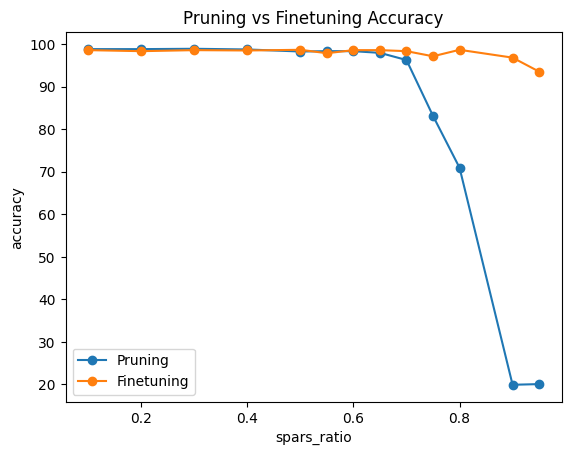

In [12]:
plt.plot(spars_lst, acc_list,'-o')
plt.plot(spars_lst, ft_acc_list,'-o')
plt.xlabel('spars_ratio')
plt.ylabel('accuracy')
plt.legend(['Pruning','Finetuning'])
plt.title('Pruning vs Finetuning Accuracy')

plt.show()

In [13]:
ft_acc_list

[98.5576923076923,
 98.3173076923077,
 98.5576923076923,
 98.4775641025641,
 98.63782051282051,
 97.83653846153847,
 98.5576923076923,
 98.5576923076923,
 98.3173076923077,
 97.11538461538461,
 98.63782051282051,
 96.7948717948718,
 93.50961538461539]